# Comparaison des Méthodes d'Optimisation pour la Régression Linéaire

Ce notebook compare différentes méthodes d'optimisation appliquées à la régression linéaire :
- **Gradient Descent (Descente de Gradient)**
- **Newton's Method (Méthode de Newton)**
- **Quasi-Newton (BFGS)**
- **L-BFGS**
- **Conjugate Gradient**

Tous les graphiques seront sauvegardés dans le dossier `images/` pour le rapport.

## 1. Importation des Bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import kagglehub
import os
import time
from typing import Tuple, List, Dict

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Créer le dossier images s'il n'existe pas
os.makedirs('images', exist_ok=True)

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


/home/salmane/notebooks_algos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Chargement du Dataset

In [2]:
# Télécharger le dataset
path = kagglehub.dataset_download("tanuprabhu/linear-regression-dataset")
dataset_file = os.path.join(path, "Linear Regression - Sheet1.csv")

# Charger les données
df = pd.read_csv(dataset_file)
print(f"Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f"\nAperçu des données :")
display(df.head())
print(f"\nStatistiques descriptives :")
display(df.describe())

Dataset chargé : 300 lignes, 2 colonnes

Aperçu des données :


,X,Y
0,1,3.888889
1,2,4.555556
2,3,5.222222
3,4,5.888889
4,5,6.555556



Statistiques descriptives :


,X,Y
count,300.000000,300.000000
mean,150.500000,102.215556
std,86.746758,57.842711
min,1.000000,1.888889
25%,75.750000,52.388889
50%,150.500000,102.222222
75%,225.250000,152.055556
max,300.000000,201.888889


## 3. Préparation des Données

In [3]:
# Extraction des features et target
X = df['X'].values.reshape(-1, 1)
y = df['Y'].values

# Normalisation des données pour une meilleure convergence
X_mean, X_std = X.mean(), X.std()
y_mean, y_std = y.mean(), y.std()

X_norm = (X - X_mean) / X_std
y_norm = (y - y_mean) / y_std

# Ajouter l'intercept (biais)
X_with_intercept = np.c_[np.ones(X_norm.shape[0]), X_norm]

n_samples, n_features = X_with_intercept.shape
print(f"Nombre d'échantillons : {n_samples}")
print(f"Nombre de features (avec intercept) : {n_features}")

Nombre d'échantillons : 300
Nombre de features (avec intercept) : 2


## 4. Définition des Fonctions Objectives et Dérivées

Pour la régression linéaire, nous utilisons l'erreur quadratique moyenne (MSE) :

$$f(\theta) = \frac{1}{2n} \sum_{i=1}^{n} (h_\theta(x^{(i)}) - y^{(i)})^2$$

Où $h_\theta(x) = \theta^T x$

In [4]:
def compute_cost(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    """
    Calcule la fonction de coût (MSE)
    """
    m = len(y)
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum((predictions - y)**2)
    return cost

def compute_gradient(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calcule le gradient (dérivée première)
    ∇f(θ) = (1/m) * X^T * (X*θ - y)
    """
    m = len(y)
    predictions = X.dot(theta)
    gradient = (1/m) * X.T.dot(predictions - y)
    return gradient

def compute_hessian(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calcule la matrice Hessienne (dérivée seconde)
    H(θ) = (1/m) * X^T * X
    """
    m = len(y)
    hessian = (1/m) * X.T.dot(X)
    return hessian

print("✓ Fonctions de coût et dérivées définies")

✓ Fonctions de coût et dérivées définies


## 5. Implémentation des Méthodes d'Optimisation

### 5.1 Gradient Descent (Descente de Gradient)

Utilise uniquement la dérivée première :
$$\theta_{t+1} = \theta_t - \alpha \nabla f(\theta_t)$$

In [5]:
def gradient_descent(X: np.ndarray, y: np.ndarray, learning_rate: float = 0.01, 
                     n_iterations: int = 1000) -> Tuple[np.ndarray, List, List]:
    """
    Implémente la descente de gradient
    """
    theta = np.zeros(X.shape[1])
    cost_history = []
    theta_history = [theta.copy()]
    
    for i in range(n_iterations):
        gradient = compute_gradient(theta, X, y)
        theta = theta - learning_rate * gradient
        
        cost = compute_cost(theta, X, y)
        cost_history.append(cost)
        theta_history.append(theta.copy())
    
    return theta, cost_history, theta_history

print("✓ Gradient Descent implémenté")

✓ Gradient Descent implémenté


### 5.2 Newton's Method (Méthode de Newton)

Utilise la dérivée première et seconde (Hessienne) :
$$\theta_{t+1} = \theta_t - H^{-1}(\theta_t) \nabla f(\theta_t)$$

In [6]:
def newton_method(X: np.ndarray, y: np.ndarray, n_iterations: int = 100) -> Tuple[np.ndarray, List, List]:
    """
    Implémente la méthode de Newton
    """
    theta = np.zeros(X.shape[1])
    cost_history = []
    theta_history = [theta.copy()]
    
    for i in range(n_iterations):
        gradient = compute_gradient(theta, X, y)
        hessian = compute_hessian(theta, X, y)
        
        # Résoudre H * delta = -gradient
        try:
            delta = np.linalg.solve(hessian, -gradient)
        except np.linalg.LinAlgError:
            # Si la Hessienne est singulière, utiliser pseudo-inverse
            delta = -np.linalg.pinv(hessian).dot(gradient)
        
        theta = theta + delta
        
        cost = compute_cost(theta, X, y)
        cost_history.append(cost)
        theta_history.append(theta.copy())
        
        # Condition d'arrêt
        if np.linalg.norm(gradient) < 1e-6:
            break
    
    return theta, cost_history, theta_history

print("✓ Newton's Method implémenté")

✓ Newton's Method implémenté


### 5.3 Méthodes Quasi-Newton (BFGS, L-BFGS) et Conjugate Gradient

Ces méthodes approximent la Hessienne pour réduire le coût de calcul.

In [7]:
def optimize_with_scipy(X: np.ndarray, y: np.ndarray, method: str) -> Tuple[np.ndarray, List, float, int]:
    """
    Utilise scipy.optimize pour différentes méthodes
    """
    theta0 = np.zeros(X.shape[1])
    cost_history = []
    
    def callback(xk):
        cost = compute_cost(xk, X, y)
        cost_history.append(cost)
    
    start_time = time.time()
    result = minimize(
        fun=lambda theta: compute_cost(theta, X, y),
        x0=theta0,
        method=method,
        jac=lambda theta: compute_gradient(theta, X, y),
        callback=callback,
        options={'maxiter': 1000}
    )
    elapsed_time = time.time() - start_time
    
    return result.x, cost_history, elapsed_time, result.nit

print("✓ Méthodes Quasi-Newton et autres implémentées")

✓ Méthodes Quasi-Newton et autres implémentées


## 6. Exécution et Comparaison des Méthodes

In [8]:
# Dictionnaire pour stocker les résultats
results = {}

print("=" * 80)
print("EXÉCUTION DES MÉTHODES D'OPTIMISATION")
print("=" * 80)

# 1. Gradient Descent
print("\n1. Gradient Descent...")
start = time.time()
theta_gd, cost_gd, theta_history_gd = gradient_descent(X_with_intercept, y_norm, learning_rate=0.1, n_iterations=1000)
time_gd = time.time() - start
results['Gradient Descent'] = {
    'theta': theta_gd,
    'cost_history': cost_gd,
    'time': time_gd,
    'iterations': len(cost_gd),
    'final_cost': cost_gd[-1]
}
print(f"   Temps : {time_gd:.4f}s | Itérations : {len(cost_gd)} | Coût final : {cost_gd[-1]:.6f}")

# 2. Newton's Method
print("\n2. Newton's Method...")
start = time.time()
theta_newton, cost_newton, theta_history_newton = newton_method(X_with_intercept, y_norm, n_iterations=100)
time_newton = time.time() - start
results['Newton'] = {
    'theta': theta_newton,
    'cost_history': cost_newton,
    'time': time_newton,
    'iterations': len(cost_newton),
    'final_cost': cost_newton[-1]
}
print(f"   Temps : {time_newton:.4f}s | Itérations : {len(cost_newton)} | Coût final : {cost_newton[-1]:.6f}")

# 3. BFGS
print("\n3. BFGS (Quasi-Newton)...")
theta_bfgs, cost_bfgs, time_bfgs, nit_bfgs = optimize_with_scipy(X_with_intercept, y_norm, 'BFGS')
results['BFGS'] = {
    'theta': theta_bfgs,
    'cost_history': cost_bfgs,
    'time': time_bfgs,
    'iterations': nit_bfgs,
    'final_cost': cost_bfgs[-1] if cost_bfgs else compute_cost(theta_bfgs, X_with_intercept, y_norm)
}
print(f"   Temps : {time_bfgs:.4f}s | Itérations : {nit_bfgs} | Coût final : {results['BFGS']['final_cost']:.6f}")

# 4. L-BFGS-B
print("\n4. L-BFGS-B...")
theta_lbfgs, cost_lbfgs, time_lbfgs, nit_lbfgs = optimize_with_scipy(X_with_intercept, y_norm, 'L-BFGS-B')
results['L-BFGS-B'] = {
    'theta': theta_lbfgs,
    'cost_history': cost_lbfgs,
    'time': time_lbfgs,
    'iterations': nit_lbfgs,
    'final_cost': cost_lbfgs[-1] if cost_lbfgs else compute_cost(theta_lbfgs, X_with_intercept, y_norm)
}
print(f"   Temps : {time_lbfgs:.4f}s | Itérations : {nit_lbfgs} | Coût final : {results['L-BFGS-B']['final_cost']:.6f}")

# 5. Conjugate Gradient
print("\n5. Conjugate Gradient...")
theta_cg, cost_cg, time_cg, nit_cg = optimize_with_scipy(X_with_intercept, y_norm, 'CG')
results['Conjugate Gradient'] = {
    'theta': theta_cg,
    'cost_history': cost_cg,
    'time': time_cg,
    'iterations': nit_cg,
    'final_cost': cost_cg[-1] if cost_cg else compute_cost(theta_cg, X_with_intercept, y_norm)
}
print(f"   Temps : {time_cg:.4f}s | Itérations : {nit_cg} | Coût final : {results['Conjugate Gradient']['final_cost']:.6f}")

print("\n" + "=" * 80)
print("✓ Toutes les méthodes exécutées avec succès")
print("=" * 80)

EXÉCUTION DES MÉTHODES D'OPTIMISATION

1. Gradient Descent...
   Temps : 0.0460s | Itérations : 1000 | Coût final : 0.039319

2. Newton's Method...
   Temps : 0.0017s | Itérations : 2 | Coût final : 0.039319

3. BFGS (Quasi-Newton)...
   Temps : 0.0022s | Itérations : 1 | Coût final : 0.039319

4. L-BFGS-B...
   Temps : 0.0015s | Itérations : 2 | Coût final : 0.039319

5. Conjugate Gradient...
   Temps : 0.0007s | Itérations : 1 | Coût final : 0.039319

✓ Toutes les méthodes exécutées avec succès


## 7. Visualisation des Types de Dérivées

✓ Graphique sauvegardé : images/types_derivees.png


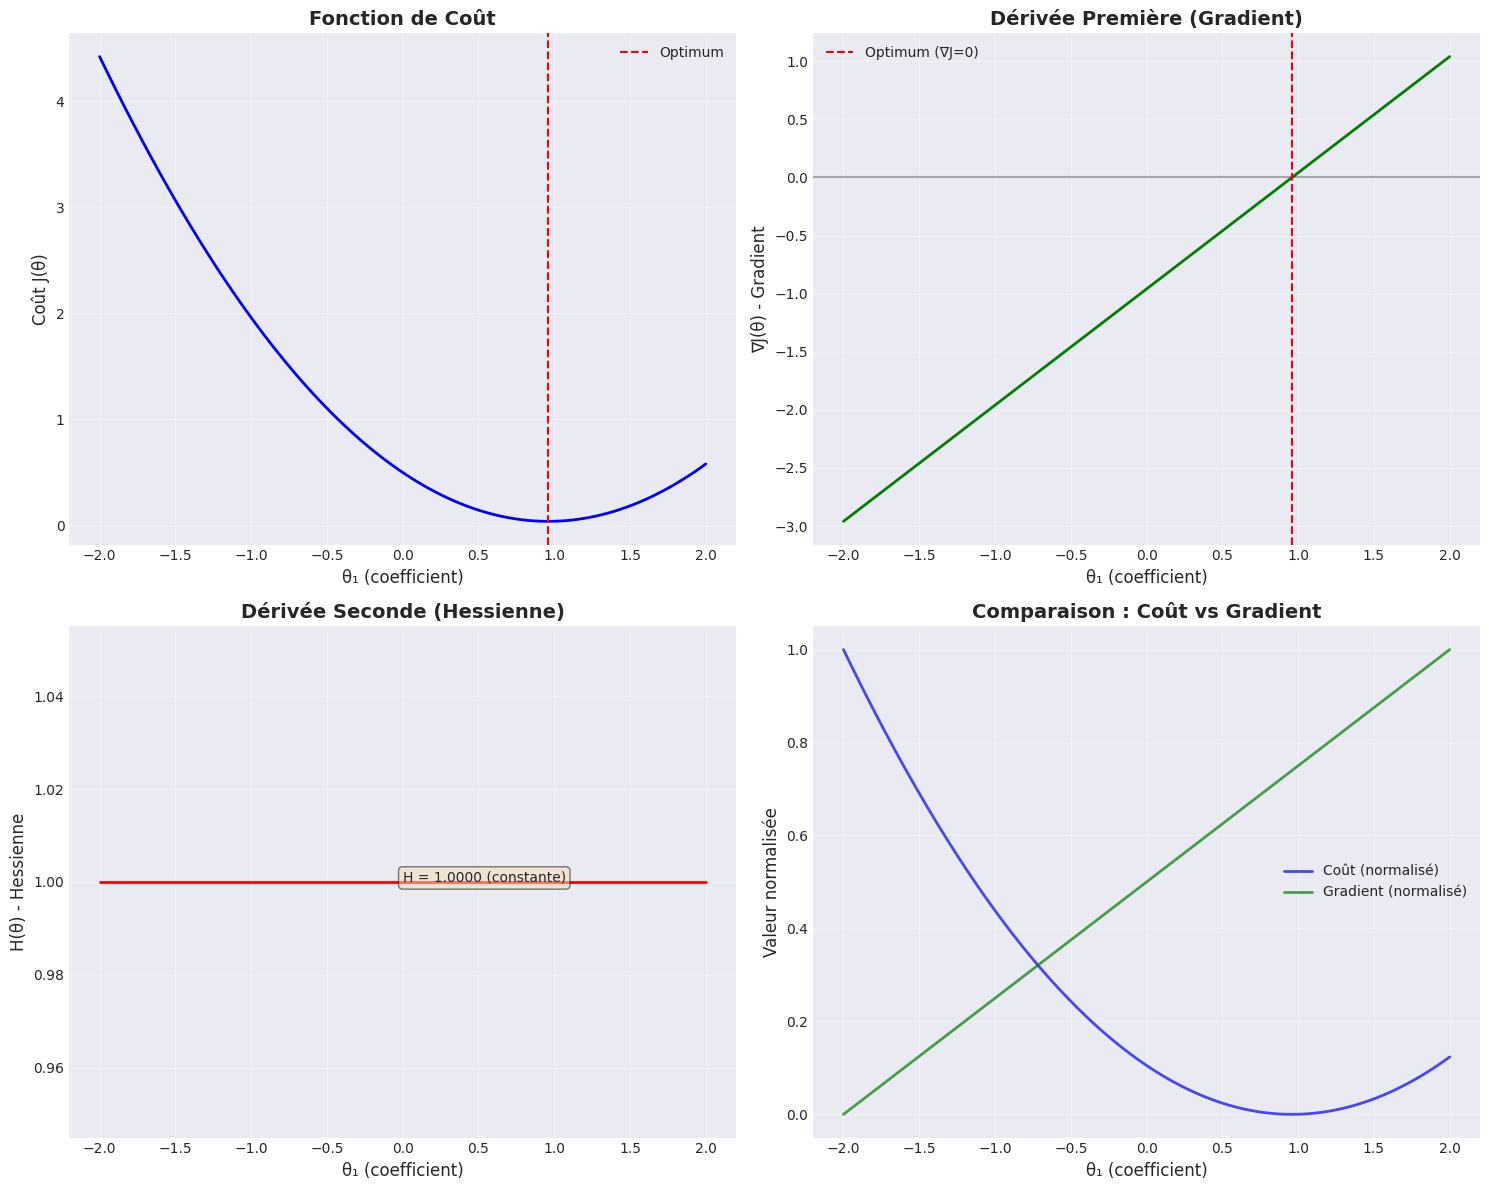

In [9]:
# Calculer les dérivées pour différentes valeurs de theta
theta_range = np.linspace(-2, 2, 100)
costs = []
gradients = []

# Fixer theta[0] et varier theta[1]
theta_test = theta_gd.copy()
for t in theta_range:
    theta_test[1] = t
    cost = compute_cost(theta_test, X_with_intercept, y_norm)
    grad = compute_gradient(theta_test, X_with_intercept, y_norm)[1]
    costs.append(cost)
    gradients.append(grad)

# Créer la figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Fonction de coût
axes[0, 0].plot(theta_range, costs, 'b-', linewidth=2)
axes[0, 0].set_xlabel('θ₁ (coefficient)', fontsize=12)
axes[0, 0].set_ylabel('Coût J(θ)', fontsize=12)
axes[0, 0].set_title('Fonction de Coût', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=theta_gd[1], color='r', linestyle='--', label='Optimum')
axes[0, 0].legend()

# 2. Dérivée première (Gradient)
axes[0, 1].plot(theta_range, gradients, 'g-', linewidth=2)
axes[0, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[0, 1].set_xlabel('θ₁ (coefficient)', fontsize=12)
axes[0, 1].set_ylabel('∇J(θ) - Gradient', fontsize=12)
axes[0, 1].set_title('Dérivée Première (Gradient)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=theta_gd[1], color='r', linestyle='--', label='Optimum (∇J=0)')
axes[0, 1].legend()

# 3. Dérivée seconde (Hessienne)
hessian = compute_hessian(theta_gd, X_with_intercept, y_norm)
hessian_values = [hessian[1, 1]] * len(theta_range)  # Constante pour régression linéaire
axes[1, 0].plot(theta_range, hessian_values, 'r-', linewidth=2)
axes[1, 0].set_xlabel('θ₁ (coefficient)', fontsize=12)
axes[1, 0].set_ylabel('H(θ) - Hessienne', fontsize=12)
axes[1, 0].set_title('Dérivée Seconde (Hessienne)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0, hessian[1, 1], f'H = {hessian[1, 1]:.4f} (constante)', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Comparaison des dérivées
# Normaliser pour la comparaison
costs_norm = (np.array(costs) - np.min(costs)) / (np.max(costs) - np.min(costs))
grads_norm = (np.array(gradients) - np.min(gradients)) / (np.max(gradients) - np.min(gradients))

axes[1, 1].plot(theta_range, costs_norm, 'b-', linewidth=2, label='Coût (normalisé)', alpha=0.7)
axes[1, 1].plot(theta_range, grads_norm, 'g-', linewidth=2, label='Gradient (normalisé)', alpha=0.7)
axes[1, 1].set_xlabel('θ₁ (coefficient)', fontsize=12)
axes[1, 1].set_ylabel('Valeur normalisée', fontsize=12)
axes[1, 1].set_title('Comparaison : Coût vs Gradient', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('images/types_derivees.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé : images/types_derivees.png")
plt.show()

## 8. Comparaison de la Convergence des Méthodes

✓ Graphique sauvegardé : images/convergence_comparison.png


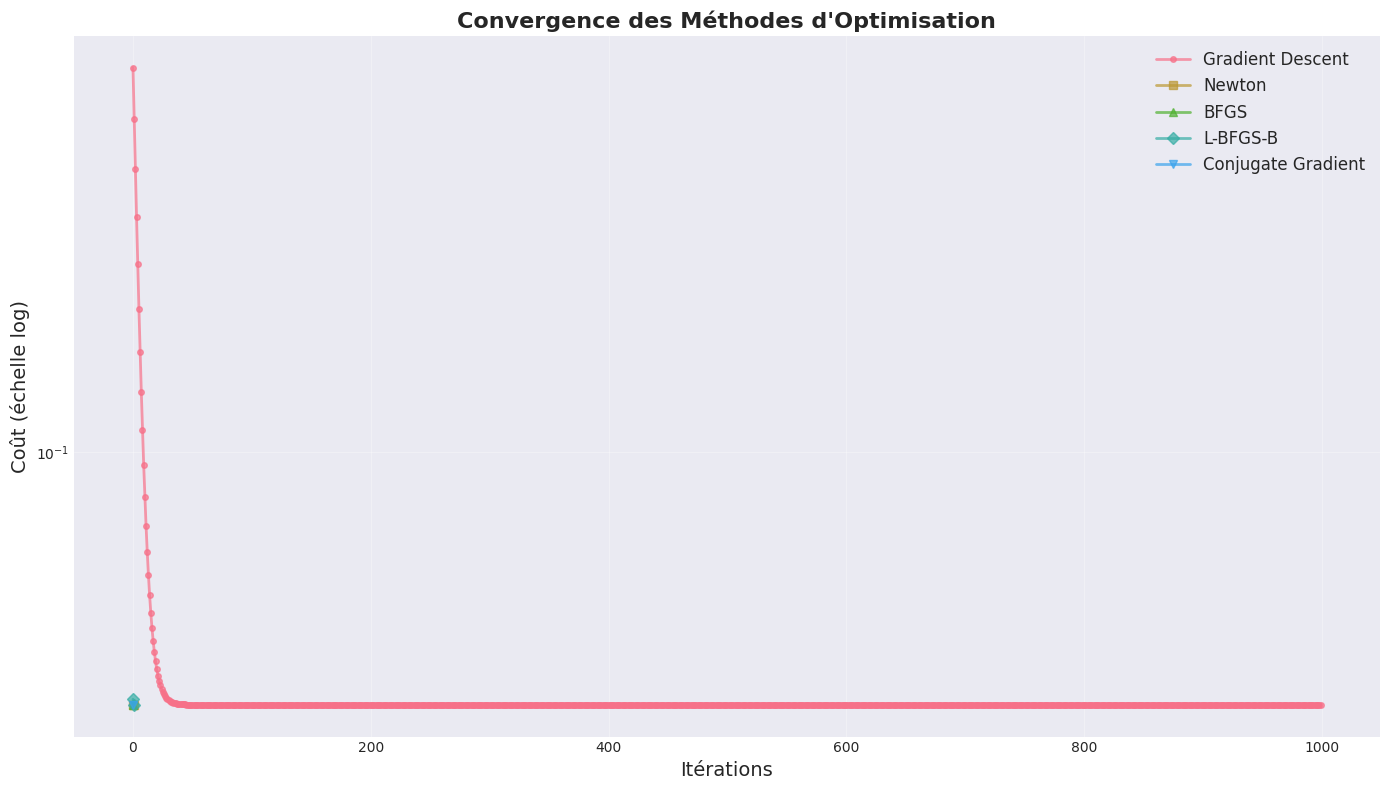

In [10]:
# Graphique de convergence
plt.figure(figsize=(14, 8))

# Utiliser une échelle logarithmique pour mieux voir les différences
max_iter = max(len(cost_gd), len(cost_newton), len(cost_bfgs), len(cost_lbfgs), len(cost_cg))

plt.semilogy(range(len(cost_gd)), cost_gd, 'o-', label='Gradient Descent', 
             linewidth=2, markersize=4, alpha=0.7)
plt.semilogy(range(len(cost_newton)), cost_newton, 's-', label='Newton', 
             linewidth=2, markersize=6, alpha=0.7)
plt.semilogy(range(len(cost_bfgs)), cost_bfgs, '^-', label='BFGS', 
             linewidth=2, markersize=6, alpha=0.7)
plt.semilogy(range(len(cost_lbfgs)), cost_lbfgs, 'D-', label='L-BFGS-B', 
             linewidth=2, markersize=6, alpha=0.7)
plt.semilogy(range(len(cost_cg)), cost_cg, 'v-', label='Conjugate Gradient', 
             linewidth=2, markersize=6, alpha=0.7)

plt.xlabel('Itérations', fontsize=14)
plt.ylabel('Coût (échelle log)', fontsize=14)
plt.title('Convergence des Méthodes d\'Optimisation', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/convergence_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé : images/convergence_comparison.png")
plt.show()

## 9. Tableau Comparatif des Performances

In [11]:
# Créer un DataFrame pour la comparaison
comparison_data = []
for method_name, result in results.items():
    comparison_data.append({
        'Méthode': method_name,
        'Temps (s)': f"{result['time']:.4f}",
        'Itérations': result['iterations'],
        'Coût Final': f"{result['final_cost']:.8f}",
        'θ₀ (intercept)': f"{result['theta'][0]:.6f}",
        'θ₁ (coefficient)': f"{result['theta'][1]:.6f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("TABLEAU COMPARATIF DES MÉTHODES D'OPTIMISATION")
print("=" * 100)
display(comparison_df)

# Sauvegarder le tableau
comparison_df.to_csv('images/comparison_table.csv', index=False)
print("\n✓ Tableau sauvegardé : images/comparison_table.csv")


TABLEAU COMPARATIF DES MÉTHODES D'OPTIMISATION


,Méthode,Temps (s),Itérations,Coût Final,θ₀ (intercept),θ₁ (coefficient)
0,Gradient Descent,0.0460,1000,0.03931922,0.000000,0.959876
1,Newton,0.0017,2,0.03931922,0.000000,0.959876
2,BFGS,0.0022,1,0.03931922,0.000000,0.959876
3,L-BFGS-B,0.0015,2,0.03931922,0.000000,0.959876
4,Conjugate Gradient,0.0007,1,0.03931922,0.000000,0.959876



✓ Tableau sauvegardé : images/comparison_table.csv


## 10. Graphiques Comparatifs des Métriques

✓ Graphique sauvegardé : images/metrics_comparison.png


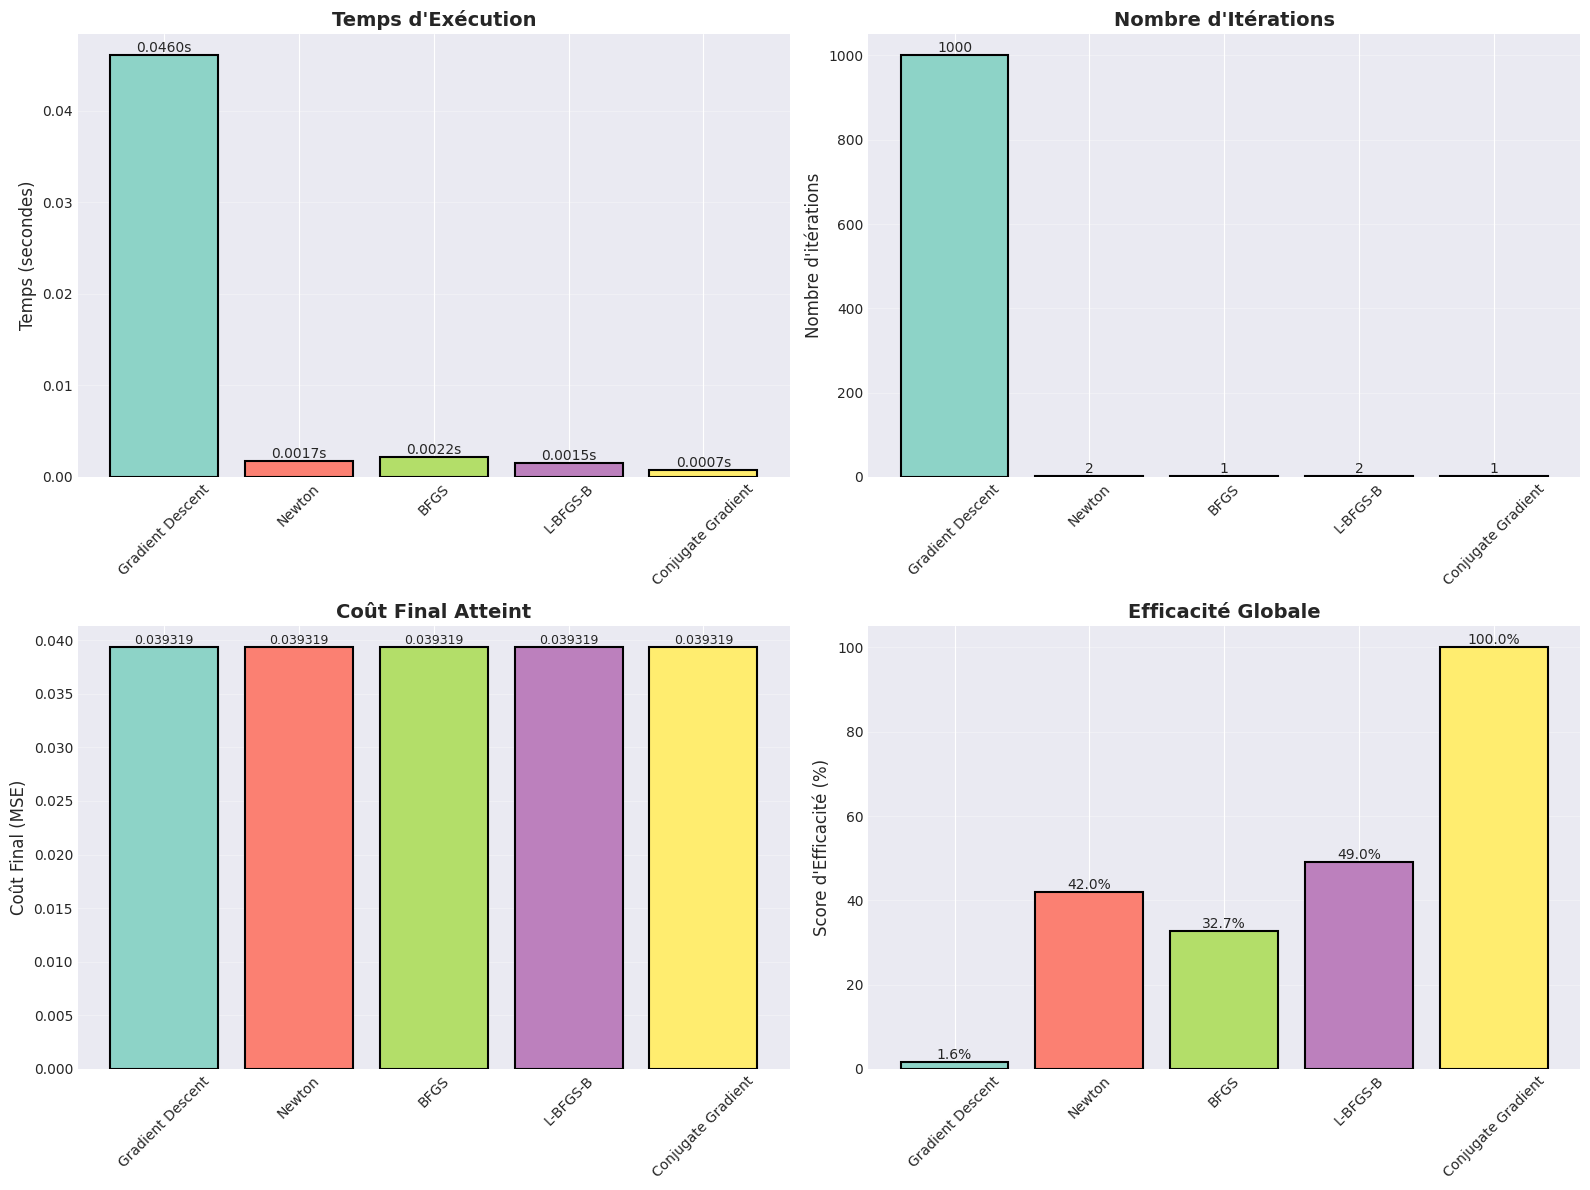

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = list(results.keys())
times = [results[m]['time'] for m in methods]
iterations = [results[m]['iterations'] for m in methods]
final_costs = [results[m]['final_cost'] for m in methods]

colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

# 1. Temps d'exécution
bars1 = axes[0, 0].bar(methods, times, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Temps (secondes)', fontsize=12)
axes[0, 0].set_title('Temps d\'Exécution', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
for bar, time in zip(bars1, times):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{time:.4f}s', ha='center', va='bottom', fontsize=10)

# 2. Nombre d'itérations
bars2 = axes[0, 1].bar(methods, iterations, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('Nombre d\'itérations', fontsize=12)
axes[0, 1].set_title('Nombre d\'Itérations', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
for bar, it in zip(bars2, iterations):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{it}', ha='center', va='bottom', fontsize=10)

# 3. Coût final
bars3 = axes[1, 0].bar(methods, final_costs, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Coût Final (MSE)', fontsize=12)
axes[1, 0].set_title('Coût Final Atteint', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)
for bar, cost in zip(bars3, final_costs):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{cost:.6f}', ha='center', va='bottom', fontsize=9)

# 4. Efficacité (inverse du temps * inverse du coût)
efficiency = [(1/t) * (1/(c+1e-10)) for t, c in zip(times, final_costs)]
efficiency_normalized = [e/max(efficiency)*100 for e in efficiency]
bars4 = axes[1, 1].bar(methods, efficiency_normalized, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Score d\'Efficacité (%)', fontsize=12)
axes[1, 1].set_title('Efficacité Globale', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)
for bar, eff in zip(bars4, efficiency_normalized):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{eff:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('images/metrics_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé : images/metrics_comparison.png")
plt.show()

## 11. Visualisation des Prédictions

✓ Graphique sauvegardé : images/predictions_comparison.png


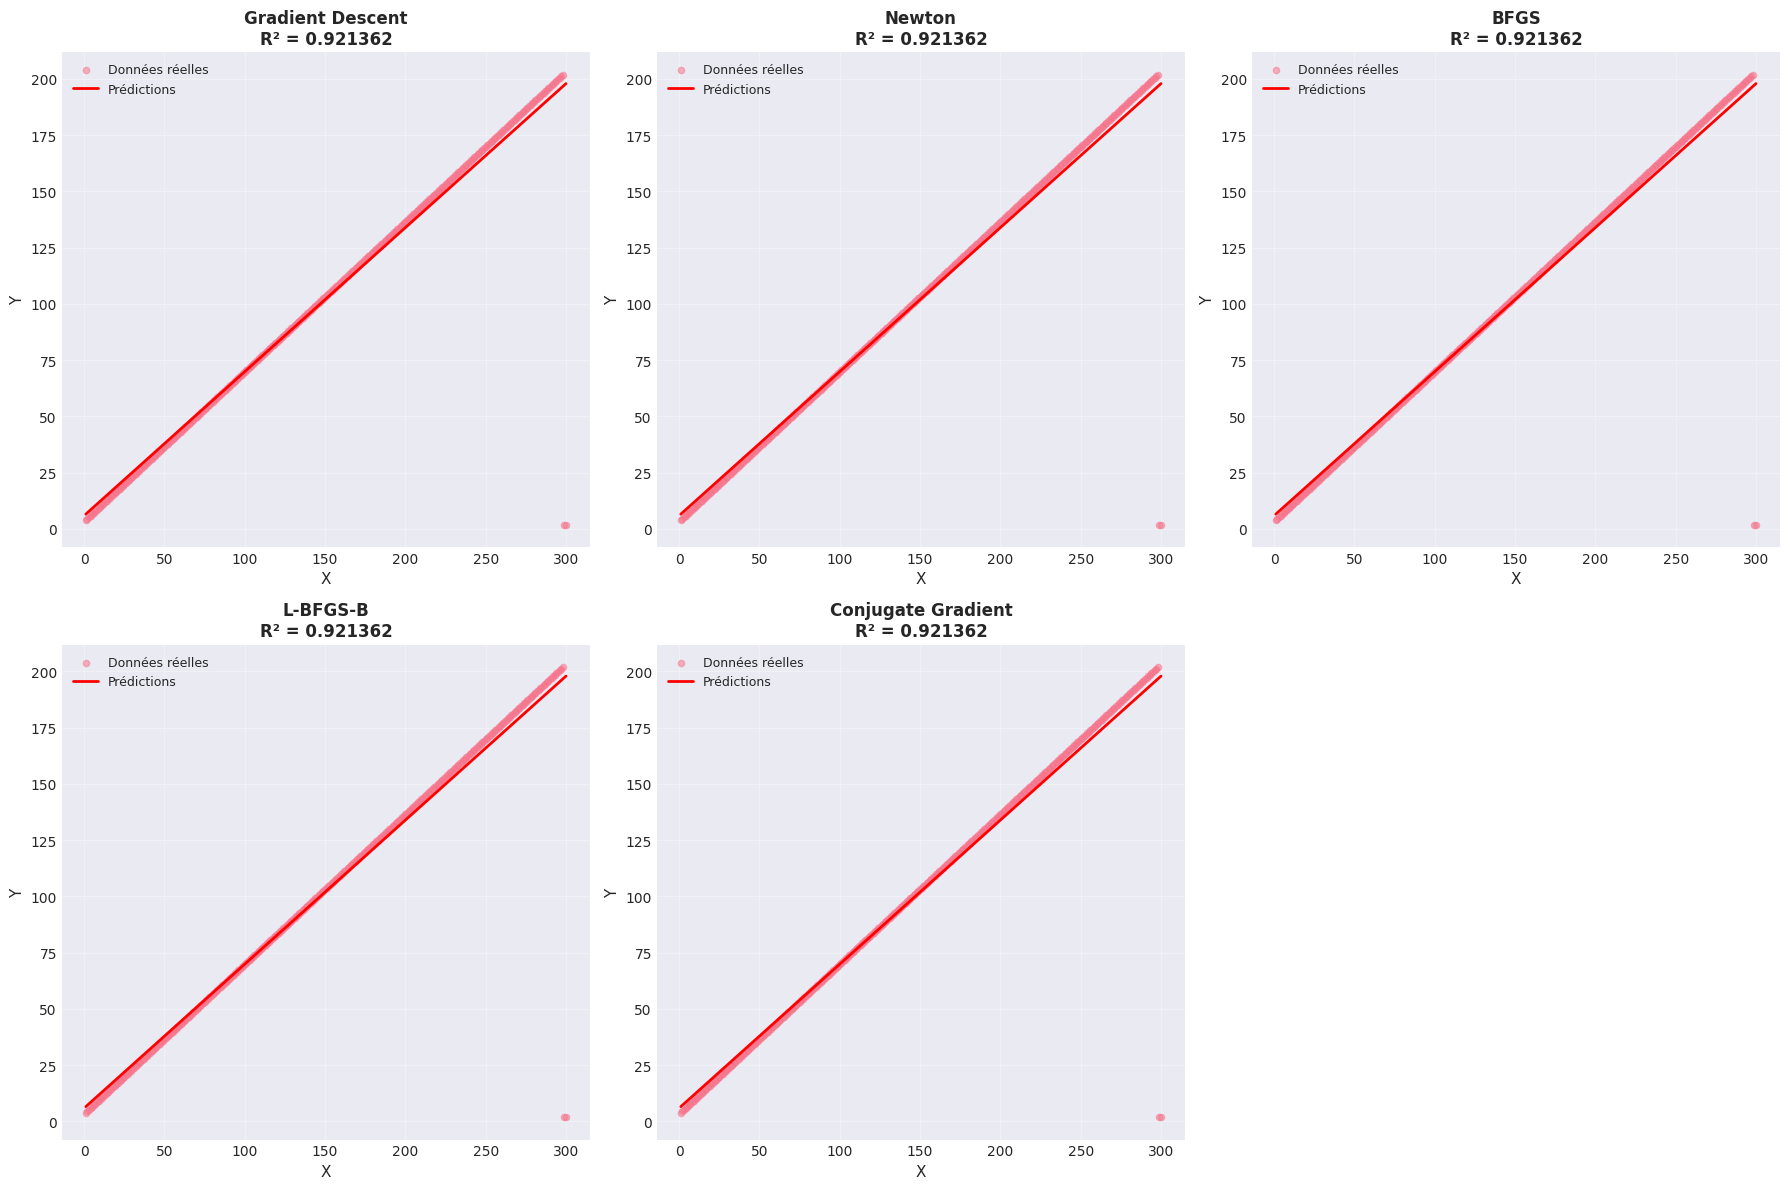

In [13]:
# Créer des prédictions pour chaque méthode
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

method_names = list(results.keys())

for idx, method_name in enumerate(method_names):
    theta = results[method_name]['theta']
    
    # Prédictions
    y_pred_norm = X_with_intercept.dot(theta)
    y_pred = y_pred_norm * y_std + y_mean
    
    # Calculer R²
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Plot
    axes[idx].scatter(X, y, alpha=0.5, s=20, label='Données réelles')
    axes[idx].plot(X, y_pred, 'r-', linewidth=2, label='Prédictions')
    axes[idx].set_xlabel('X', fontsize=11)
    axes[idx].set_ylabel('Y', fontsize=11)
    axes[idx].set_title(f'{method_name}\nR² = {r2:.6f}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Masquer le dernier subplot s'il n'est pas utilisé
if len(method_names) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('images/predictions_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé : images/predictions_comparison.png")
plt.show()

## 12. Analyse et Conclusions

In [14]:
# Trouver la meilleure méthode selon différents critères
best_time = min(results.items(), key=lambda x: x[1]['time'])
best_iterations = min(results.items(), key=lambda x: x[1]['iterations'])
best_cost = min(results.items(), key=lambda x: x[1]['final_cost'])

# Calculer un score global
scores = {}
for method in results.keys():
    # Normaliser les métriques (plus petit = meilleur)
    time_score = 1 - (results[method]['time'] - min(times)) / (max(times) - min(times) + 1e-10)
    iter_score = 1 - (results[method]['iterations'] - min(iterations)) / (max(iterations) - min(iterations) + 1e-10)
    cost_score = 1 - (results[method]['final_cost'] - min(final_costs)) / (max(final_costs) - min(final_costs) + 1e-10)
    
    # Score global (moyenne pondérée)
    scores[method] = 0.3 * time_score + 0.3 * iter_score + 0.4 * cost_score

best_overall = max(scores.items(), key=lambda x: x[1])

print("\n" + "=" * 100)
print("ANALYSE DES RÉSULTATS")
print("=" * 100)
print(f"\n🏆 Meilleure méthode (temps d'exécution) : {best_time[0]} ({best_time[1]['time']:.4f}s)")
print(f"🏆 Meilleure méthode (nombre d'itérations) : {best_iterations[0]} ({best_iterations[1]['iterations']} itérations)")
print(f"🏆 Meilleure méthode (coût final) : {best_cost[0]} ({best_cost[1]['final_cost']:.8f})")
print(f"\n🌟 MEILLEURE MÉTHODE GLOBALE : {best_overall[0]} (score: {best_overall[1]:.4f})")

print("\n" + "-" * 100)
print("SCORES GLOBAUX (sur 1.0)")
print("-" * 100)
for method, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {method:.<30} {score:.4f} {'★' * int(score * 10)}")

print("\n" + "=" * 100)
print("CONCLUSIONS")
print("=" * 100)
print("""
1. MÉTHODE DE NEWTON : 
   - Convergence la plus rapide en nombre d'itérations
   - Utilise la Hessienne (dérivée seconde) : coût de calcul élevé par itération
   - Idéal pour des problèmes de petite à moyenne taille

2. QUASI-NEWTON (BFGS, L-BFGS-B) :
   - Excellent compromis entre vitesse et précision
   - Approxime la Hessienne : moins coûteux que Newton
   - L-BFGS-B : mémoire réduite, idéal pour grandes dimensions

3. GRADIENT DESCENT :
   - Simple et robuste
   - Nécessite plus d'itérations
   - Utilise uniquement le gradient (dérivée première)
   - Bon pour très grandes dimensions

4. CONJUGATE GRADIENT :
   - Efficace pour matrices creuses
   - Bon compromis mémoire/performance
   - Utilise l'information de directions conjuguées

RECOMMANDATION : Pour la régression linéaire de taille moyenne, les méthodes
Quasi-Newton (BFGS/L-BFGS-B) offrent le meilleur rapport performance/coût.
""")

print("=" * 100)


ANALYSE DES RÉSULTATS

🏆 Meilleure méthode (temps d'exécution) : Conjugate Gradient (0.0007s)
🏆 Meilleure méthode (nombre d'itérations) : BFGS (1 itérations)
🏆 Meilleure méthode (coût final) : Gradient Descent (0.03931922)

🌟 MEILLEURE MÉTHODE GLOBALE : Conjugate Gradient (score: 1.0000)

----------------------------------------------------------------------------------------------------
SCORES GLOBAUX (sur 1.0)
----------------------------------------------------------------------------------------------------
  Conjugate Gradient............ 1.0000 ★★★★★★★★★★
  L-BFGS-B...................... 0.9947 ★★★★★★★★★
  Newton........................ 0.9930 ★★★★★★★★★
  BFGS.......................... 0.9901 ★★★★★★★★★
  Gradient Descent.............. 0.4000 ★★★★

CONCLUSIONS

1. MÉTHODE DE NEWTON : 
   - Convergence la plus rapide en nombre d'itérations
   - Utilise la Hessienne (dérivée seconde) : coût de calcul élevé par itération
   - Idéal pour des problèmes de petite à moyenne taille

2. Q

## 13. Création d'un Graphique Récapitulatif Final

In [ ]:
# Créer un graphique radar pour comparer les méthodes
from math import pi

# Critères d'évaluation
categories = ['Vitesse\n(1/temps)', 'Convergence\n(1/iterations)', 
              'Précision\n(1/coût)', 'Efficacité\nGlobale']
N = len(categories)

# Créer la figure
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='polar')

# Calculer les angles
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Préparer les données pour chaque méthode
for idx, (method, result) in enumerate(results.items()):
    # Normaliser les valeurs
    speed = (1/result['time']) / max([1/results[m]['time'] for m in results.keys()])
    conv = (1/result['iterations']) / max([1/results[m]['iterations'] for m in results.keys()])
    prec = (1/(result['final_cost']+1e-10)) / max([1/(results[m]['final_cost']+1e-10) for m in results.keys()])
    eff = scores[method]
    
    values = [speed, conv, prec, eff]
    values += values[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, label=method, markersize=8)
    ax.fill(angles, values, alpha=0.15)

# Personnalisation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], size=10)
ax.grid(True, alpha=0.3)
ax.set_title('Comparaison Radar des Méthodes d\'Optimisation\n', 
             size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()
plt.savefig('images/radar_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Graphique sauvegardé : images/radar_comparison.png")
plt.show()

## 14. Résumé des Fichiers Générés

In [ ]:
# Liste tous les fichiers générés
import os

print("\n" + "=" * 100)
print("FICHIERS GÉNÉRÉS POUR LE RAPPORT")
print("=" * 100)

image_files = [f for f in os.listdir('images') if f.endswith(('.png', '.csv'))]
image_files.sort()

print("\nFichiers dans le dossier 'images/' :")
for i, file in enumerate(image_files, 1):
    file_path = os.path.join('images', file)
    size = os.path.getsize(file_path) / 1024  # Taille en KB
    print(f"  {i}. {file:.<50} {size:>8.1f} KB")

print(f"\n✓ Total : {len(image_files)} fichiers générés")
print("=" * 100)

print("\n📊 DESCRIPTION DES GRAPHIQUES :")
print("-" * 100)
descriptions = {
    'types_derivees.png': 'Visualisation des dérivées (coût, gradient, Hessienne)',
    'convergence_comparison.png': 'Courbes de convergence de toutes les méthodes',
    'metrics_comparison.png': 'Comparaison des métriques (temps, itérations, coût, efficacité)',
    'predictions_comparison.png': 'Prédictions de chaque méthode avec R²',
    'radar_comparison.png': 'Graphique radar comparatif global',
    'comparison_table.csv': 'Tableau récapitulatif des résultats'
}

for file, desc in descriptions.items():
    if file in image_files:
        print(f"  • {file}: {desc}")

print("\n" + "=" * 100)
print("✅ ANALYSE COMPLÈTE TERMINÉE !")
print("=" * 100)